<a href="https://colab.research.google.com/github/Yin-Tzu/predict_DA_reaction_product2/blob/main/3molecule_pi_orbital_filter/defferent_C_eig_2CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import cv2
import copy

tStart = time.time()#計時開始
datafile1 = u'./X_train.npy'
datafile2 = u'./y_train.npy'
datafile3 = u'./X_test.npy'
datafile4 = u'./y_test.npy'
datafile5 = u'./X_test2.npy'
datafile6 = u'./y_test2.npy'
X_train,y_train_label,X_test,y_test_label = np.load(datafile1), np.load(datafile2), np.load(datafile3), np.load(datafile4)
print(X_train.shape,y_train_label.shape,X_test.shape,y_test_label.shape)
X_2,y_2 = np.load(datafile5), np.load(datafile6)

y_Test2 = tf.keras.utils.to_categorical(y_2)
y_TrainOneHot = tf.keras.utils.to_categorical(y_train_label)  # One-Hot编码
y_TestOneHot = tf.keras.utils.to_categorical(y_test_label)

model = tf.keras.models.Sequential()  # 调用Sequential模型
model.add(layers.Conv2D(input_shape=(6,3, 1), filters=16, kernel_size=(3,3), kernel_initializer='TruncatedNormal', strides=1, padding='same', activation='relu', name='conv1')) # 只需要input_shape改變(2,3,1)(4,3,1)(6,3,1)... 
model.add(layers.AveragePooling2D(pool_size=(2,2), strides=2, padding='same', name='pool1'))  # AveragePooling2D
model.add(layers.Flatten(name='flatten'))
model.add(layers.Dense(units=64, kernel_initializer='TruncatedNormal', activation='relu'))
model.add(layers.Dense(units=3,kernel_initializer='TruncatedNormal', activation='softmax'))  # 兩個C的output需改成units=2，其他事units=3

print(model.summary())

# 模型的训练 编译模型
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# 训练模型
train_history = model.fit(x=X_train, y=y_TrainOneHot,validation_split=0.25, epochs=200, batch_size=2, verbose=2)  # ,validation_data=(X_valid, y_ValidOneHot), callbacks=[es])#,validation_split=0.25  callbacks=[tensorboard_callback])  # verbose日志显示，0为不在标准输出流输出日志信息，1为输出进度条记录，2为每个epoch输出一行记录
# 查看训练过程，之前的训练步骤的值都保存在这里面。这里共有loss,accuracy,val_loss,val_accuracy四个参数
print(train_history.history)


#測試的loss及準確率
scores = model.evaluate(X_test,y_TestOneHot)
print('loss, accuracy=',scores) #显示测试准确率[1]

scores2 = model.evaluate(X_2,y_Test2)
print('loss, accuracy=',scores) #显示测试准确率[1]

prediction = model.predict_classes(X_test)
prediction2 = model.predict_classes(X_2)
# 返回预测属于某标签的概率
y_score = model.predict_proba(X_2)
#print(y_score)

# 將模型儲存至 HDF5 檔案中
model.save('eig_model.h5')  # creates a HDF5 file 'my_model.h5'

tEnd = time.time()#計時結束
#列印結果
print("It cost %f sec" % (tEnd - tStart))  #會自動做近位
print(tEnd - tStart)  #原型長這樣



(240, 6, 3, 1) (240,) (60, 6, 3, 1) (60,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 6, 3, 16)          160       
_________________________________________________________________
pool1 (AveragePooling2D)     (None, 3, 2, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 96)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                6208      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 6,563
Trainable params: 6,563
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
90/90 - 1s - loss: 1.0872 - accuracy: 0.3833 - val_loss: 1.08

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


It cost 30.675106 sec
30.675106287002563


性能1

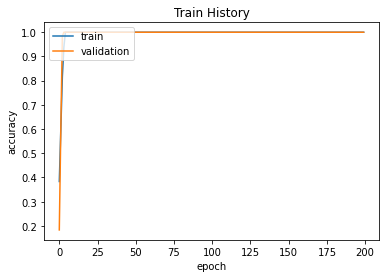

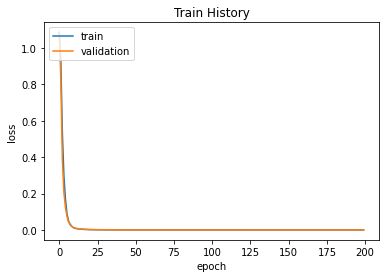

predict   0   1   2
label              
0        24   0   0
1         0  18   0
2         0   0  18
predict   0   1   2
label              
0        72   0   0
1         0  72   0
2         0   0  72


In [ ]:
def show_train_history(train_history, train, validation):  # 訓練集驗證準確度對epoch做圖
    plt.plot(train_history.history[train])  # 绘制训练数据的执行结果
    plt.plot(train_history.history[validation])  # 绘制验证数据的执行结果
    plt.title('Train History')  # 图标题
    plt.xlabel('epoch')  # x轴标签
    plt.ylabel(train)  # y轴标签
    plt.legend(['train', 'validation'], loc='upper left')  # 添加左上角图例
    plt.show()

show_train_history(train_history, 'accuracy', 'val_accuracy')

show_train_history(train_history, 'loss', 'val_loss')

print(pd.crosstab(y_test_label,prediction,rownames=['label'],colnames=['predict']))

print(pd.crosstab(y_2,prediction2,rownames=['label'],colnames=['predict']))   # https://zhuanlan.zhihu.com/p/52368125  其他呈現交叉表方法(平均、彩色圖...)X_2,y_Test2   y_test_label,prediction



性能2

https://ithelp.ithome.com.tw/articles/10222697

precision = true positive(tp)/true positive(TP) + false positive(FP) 預測正例的數量中，有多少是預測正確的(FN不重要(正例預測成反例不重要)(ex:正例是沒病毒，沒病毒也戴口罩、正例是晴天，晴天帶雨傘)(反例比較重要))

recall = true positive(tp)/true positive(tp)+false negative(fn) 真實是正例的數量中，有多少是預測正確的(FP不重要(反例預測成正例不重要)(ex:正例是有病毒，沒病毒也戴口罩、正例是雨天，晴天帶雨傘)(正例比較重要))

macro avg = 上面的column平均

weighted avg = 上面的column加權平均

support = 樣本數量

f1-score = 2 * PR / P + R = TP / TP + (FN + FP / 2)

In [ ]:
# Print the precision and recall, among other metrics
print(metrics.classification_report(y_test_label, prediction,digits=3))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000         3
           1      1.000     1.000     1.000         5
           2      1.000     1.000     1.000        52

    accuracy                          1.000        60
   macro avg      1.000     1.000     1.000        60
weighted avg      1.000     1.000     1.000        60



https://blog.csdn.net/xtingjie/article/details/72803029?utm_medium=distribute.pc_relevant.none-task-blog-BlogCommendFromBaidu-2.control&depth_1-utm_source=distribute.pc_relevant.none-task-blog-BlogCommendFromBaidu-2.control



In [ ]:
from sklearn.metrics import cohen_kappa_score

# kappa
kappa = cohen_kappa_score(y_test_label, prediction)
print('Cohens kappa: %f' % kappa)


Cohens kappa: 1.000000
